In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygad
from sklearn.decomposition import PCA
from scipy.optimize import linprog
from scipy.spatial import KDTree
from sklearn.manifold import TSNE

import time

from blog_utils import *

## Method signatures
* dense_pairwise_distances(points)  Computes dense pairwise distance matrix on points
* cross_dist(points, targets)  Computes Euclidean distance between point_i and every target in targets_i as an i,k matrix
* get_top_nn(points, k)  Gets the indices of the top-K nearest neighbors of every point in points
* embed_in_high_dim(points, embed_dim)  linearly embeds low-d manifold into higher dimensional space

### embedding methods
* make_tsne_embedding(points)
* make_mds_embedding(points)
* make_pca_embedding(points)

### embedding distance methods
* nn_cos_sim_distance(points_a, points_b, num_nn)
* iou_distance(points_a, points_b, num_nn)

### sampling methods
* sample_sphere(manifold_dim, num_points, snr)  samples from n-dimensional spherical surface
* sample_hypercube(manifold_dim, num_points, snr)  samples from n-dimensional hypercube surface, avoiding exact corners
* sample_torus(num_points, snr, tube_radius, outer_radius)  samples from 3-d torus  (adapt to n-d somehow?????)

In [2]:
def helper_triple_plot(manifold_dim, embedding_dim, embed_type, *, num_nn=15, snr=10, num_points=2000):
    point_groups = [
        sample_sphere(manifold_dim, num_points, snr),
        sample_hypercube(manifold_dim, num_points, snr),
    ]
    manifold_names = ['sphere', 'cube']
    if manifold_dim == 3:
        point_groups.append(sample_torus(num_points, snr, 1, 3))
        manifold_names.append('torus')
    
    point_groups = [embed_in_high_dim(pcloud, embedding_dim) for pcloud in point_groups]
    
    if embed_type == 'pca':
        embeddings = [make_pca_embedding(pcloud) for pcloud in point_groups]
    elif embed_type == 'tsne':
        embeddings = [make_tsne_embedding(pcloud) for pcloud in point_groups]
    else:
        embeddings = [make_mds_embedding(pcloud) for pcloud in point_groups]
    
    for points, embed_points, mname in zip(point_groups, embeddings, manifold_names):
        points = (points - points.mean()) / points.var()
        
        fig_title = f'{manifold_dim}-d {mname.capitalize()} Embedded in {embedding_dim}-d Space.'
        fname = fig_title.replace('-', '_').replace(' ', '_')
        
        helper_plot_err(points, embed_points, embed_type, fig_title, fname, num_nn=num_nn)


In [3]:
nonuniform_pmf = (0.07
    + make_gaussian([0.65, 0.75], 0.05, 200)
    + make_gaussian([0.25, 0.55], [0.10, 0.07], 200)
    + make_gaussian([0.85, 0.15], [0.05, 0.2], 200)
)
nonuniform_pmf /= nonuniform_pmf.sum()

nonuniform_sample = sample_cloth(2000, nonuniform_pmf)
uniform_sample = sample_cloth(2000)

nonuniform_sample = embed_in_high_dim(nonuniform_sample, 10)
uniform_sample = embed_in_high_dim(uniform_sample, 10)

In [9]:
nonuniform_tsne = make_tsne_embedding(nonuniform_sample)
nonuniform_umap = make_umap_embedding(nonuniform_sample)

In [10]:
uniform_tsne = make_tsne_embedding(uniform_sample)
uniform_umap = make_umap_embedding(uniform_sample)

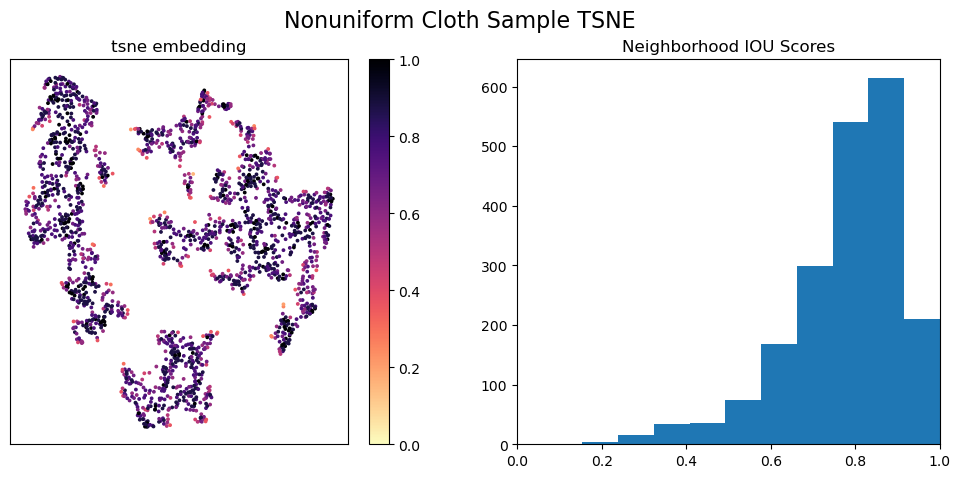

In [11]:
helper_plot_err(nonuniform_sample, nonuniform_tsne, 'tsne', 'Nonuniform Cloth Sample TSNE', None)

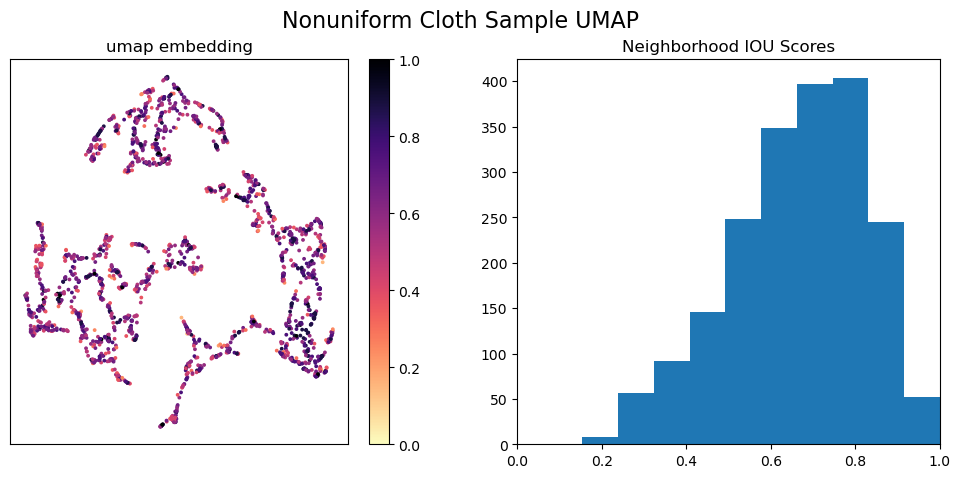

In [12]:
helper_plot_err(nonuniform_sample, nonuniform_umap, 'umap', 'Nonuniform Cloth Sample UMAP', None)

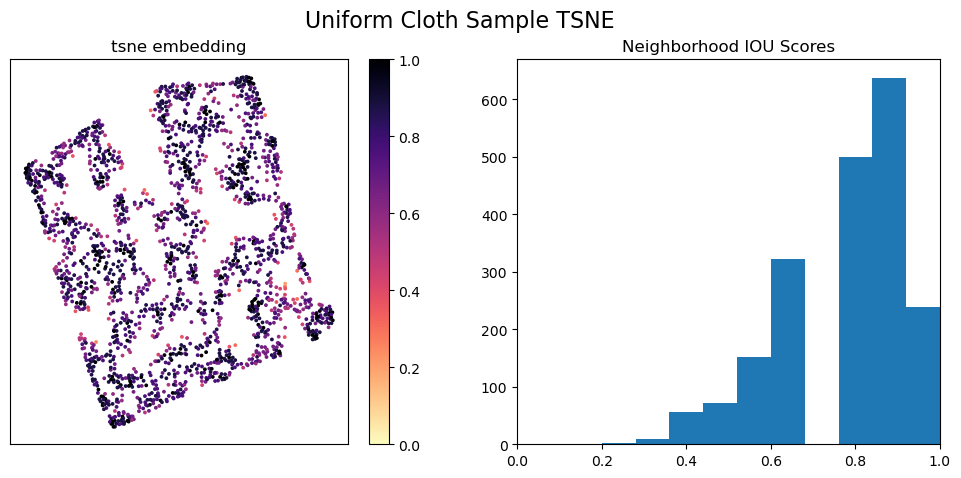

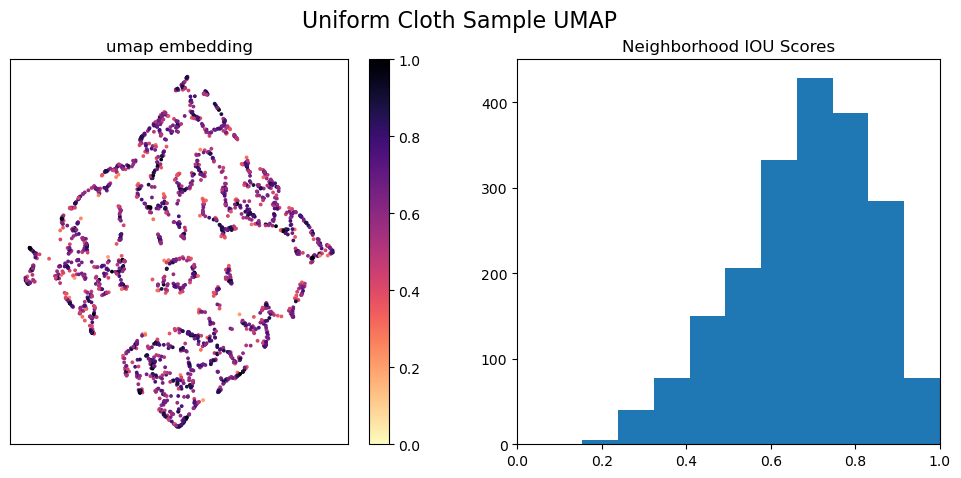

In [13]:
helper_plot_err(uniform_sample, uniform_tsne, 'tsne', 'Uniform Cloth Sample TSNE', None)
helper_plot_err(uniform_sample, uniform_umap, 'umap', 'Uniform Cloth Sample UMAP', None)

In [16]:
umaps_uniform = {}
for n in (2, 5, 10, 20, 50, 100, 200):
    for min_dist in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
        umaps_uniform[f'{n}_{min_dist:.2f}'] = make_umap_embedding(uniform_sample, n_neighbors=n, min_dist=min_dist)

In [19]:
umaps_nonuniform = {}
for n in (2, 5, 10, 20, 50, 100, 200):
    for min_dist in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
        umaps_nonuniform[f'{n}_{min_dist:.2f}'] = make_umap_embedding(nonuniform_sample, n_neighbors=n, min_dist=min_dist)

/opt/homebrew/Caskroom/miniforge/base/envs/blog/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/blog/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
